In [1]:
from poisson_fem import PoissonFEM
import ROM
import numpy as np
import scipy.sparse as sps
import scipy.sparse.linalg as lg
import time
import petsc4py
import sys
petsc4py.init(sys.argv)
from petsc4py import PETSc

In [2]:
lin_dim_rom = 16
mesh = PoissonFEM.RectangularMesh(np.ones(lin_dim_rom)/lin_dim_rom)
# mesh.plot()

In [3]:
def origin(x):
    return np.abs(x[0]) < np.finfo(float).eps and np.abs(x[1]) < np.finfo(float).eps
def essBoundaryFun(x):
    return 1.0
mesh.setEssentialBoundary(origin, essBoundaryFun)

In [4]:
def domainBoundary(x):
    # unit square
    return np.abs(x[0]) < np.finfo(float).eps or np.abs(x[1]) < np.finfo(float).eps or \
            np.abs(x[0]) > 1.0 - np.finfo(float).eps or np.abs(x[1]) > 1.0 - np.finfo(float).eps
mesh.setNaturalBoundary(domainBoundary)

In [5]:
#Define boundary flux field
def flux(x):
    a = np.array([1, 2, 3])
    q = np.array([a[0] + a[2]*x[1], a[1] + a[2]*x[0]])
    return q

In [6]:
rhs = PoissonFEM.RightHandSide(mesh)
rhs.setNaturalRHS(mesh, flux)

In [7]:
funSpace = PoissonFEM.FunctionSpace(mesh)
K = PoissonFEM.StiffnessMatrix(mesh, funSpace)

In [8]:
rhs.setRhsStencil(mesh, K)

In [9]:
# Preallocate
x = PETSc.Vec().createSeq(mesh.nEq)

In [10]:
# Set up solver
ksp = PETSc.KSP().create()
ksp.setType('preonly')
pc = ksp.getPC()
pc.setType('cholesky')
ksp.setFromOptions() #???

In [11]:
# define rom
rom = ROM.ROM(mesh, K, rhs, ksp)

In [12]:
N = 1e4

In [13]:
lmbda = PETSc.Vec().createSeq(mesh.nCells)
start = time.time()
for n in range(int(N)):
    lmbda.setValues(range(mesh.nCells), np.arange(5.0, lin_dim_rom**2 + 5.0))
    
    # solve implies stiffness/ rhs assembly and solution
    rom.solve(lmbda)
petsc_time = (time.time() - start)/N
print('PETSc time = ', petsc_time)

PETSc time =  0.00024042444229125976


In [14]:
# for scipy comparison
Kes = K.globStiffStencil.getValuesCSR()
Kes = sps.csr_matrix((Kes[2], Kes[1], Kes[0]))

In [15]:
start = time.time()
for n in range(int(N)):
    Kvecs = Kes @ lmbda.array
    K1 = sps.csr_matrix((Kvecs[K.vec_nonzero], K.indices, K.indptr))
    rhs.assemble(lmbda)   # for fair comparison
    x1 = lg.spsolve(K1, rhs.vector.array)
scipy_time = (time.time() - start)/N
print('scipy time = ', scipy_time)

scipy time =  0.0009586205720901489


In [16]:
diff = np.linalg.norm(rom.solution.array - x1)/np.linalg.norm(x1)
print('result difference = ', diff)
print('PETSc speedup = ', scipy_time/petsc_time)

result difference =  4.227336507310977e-13
PETSc speedup =  3.987200980709098


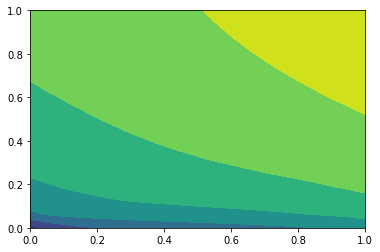

In [17]:
# plot
rom.plotSolution()